In [1]:
!pip install caer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 94.7 MB/s eta 0:00:00


In [2]:
import os
import caer
import numpy as np
import cv2 as cv
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

2024-06-18 19:17:35.597853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 19:17:35.597952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 19:17:35.726060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [4]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
print(char_dict)

# Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
print(characters)

[('homer_simpson', 2246), ('ned_flanders', 1454), ('moe_szyslak', 1452), ('lisa_simpson', 1354), ('bart_simpson', 1342), ('marge_simpson', 1291), ('krusty_the_clown', 1206), ('principal_skinner', 1194), ('charles_montgomery_burns', 1193), ('milhouse_van_houten', 1079), ('chief_wiggum', 986), ('abraham_grampa_simpson', 913), ('sideshow_bob', 877), ('apu_nahasapeemapetilon', 623), ('kent_brockman', 498), ('comic_book_guy', 469), ('edna_krabappel', 457), ('nelson_muntz', 358), ('lenny_leonard', 310), ('mayor_quimby', 246), ('waylon_smithers', 181), ('maggie_simpson', 128), ('groundskeeper_willie', 121), ('barney_gumble', 106), ('selma_bouvier', 103), ('carl_carlson', 98), ('ralph_wiggum', 89), ('patty_bouvier', 72), ('martin_prince', 71), ('professor_john_frink', 65), ('snake_jailbird', 55), ('cletus_spuckler', 47), ('rainier_wolfcastle', 45), ('simpsons_dataset', 42), ('agnes_skinner', 42), ('sideshow_mel', 40), ('otto_mann', 32), ('fat_tony', 27), ('gil', 27), ('miss_hoover', 17), ('dis

In [5]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

# Number of training samples
print(len(train))

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 1.98675537109375s
[INFO] At 1000 files
[INFO] 1454 files found in 0.6382956504821777s
[INFO] At 1000 files
[INFO] 1452 files found in 0.6000351905822754s
[INFO] At 1000 files
[INFO] 1354 files found in 0.46026134490966797s
[INFO] At 1000 files
[INFO] 1342 files found in 0.37235522270202637s
[INFO] At 1000 files
[INFO] 1291 files found in 0.28161168098449707s
[INFO] At 1000 files
[INFO] 1206 files found in 0.1549685001373291s
[INFO] At 1000 files
[INFO] 1194 files found in 0.10650229454040527s
[INFO] At 1000 files
[INFO] 1193 files found in 0.10652589797973633s
[INFO] At 1000 files
[INFO] 1079 files found in 0.00455164909362793s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 1m 33s
13811


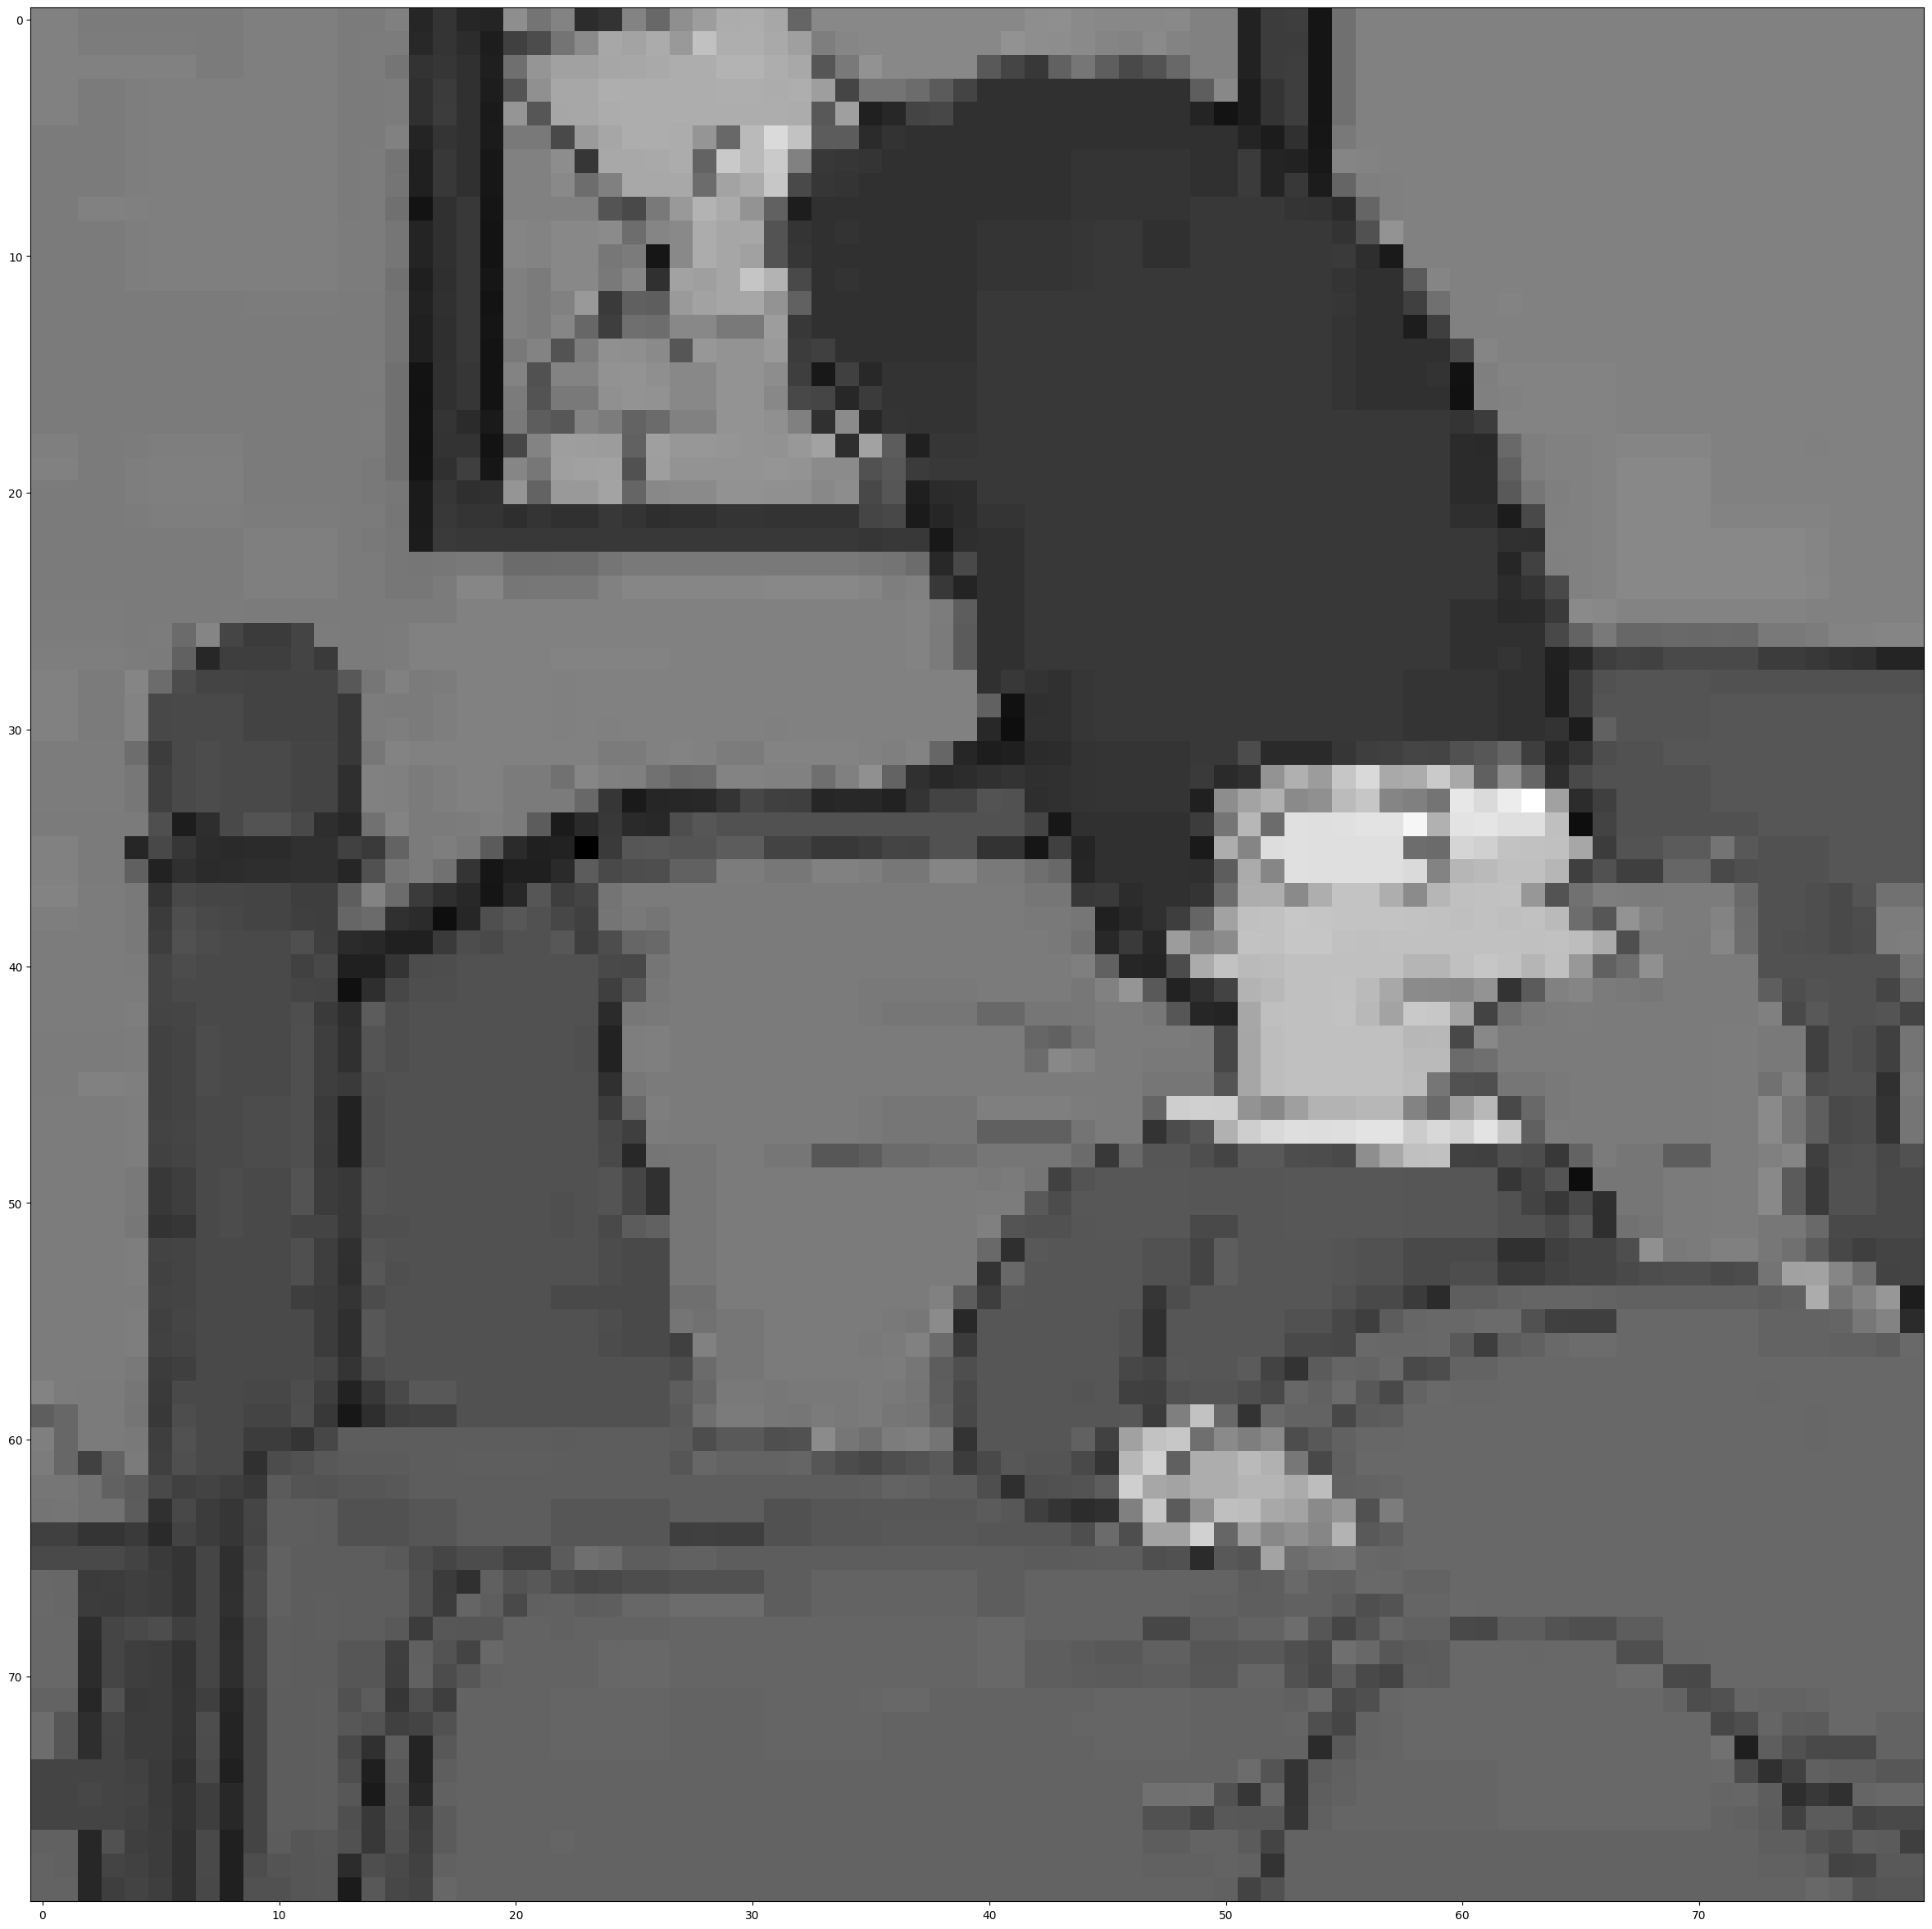

In [6]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
plt.figure(figsize=(30, 30))
plt.imshow(train[0][0], cmap='gray')
plt.show()


In [7]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

# Normalize the featureSet ==> (0, 1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

# Creating train and validation data
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [8]:
# Deleting variables to save memory
del train
del featureSet
del labels
gc.collect()

0

In [9]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

# Image data generator (introduces randomness in network ==> better accuracy)
datagen = ImageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [10]:
def create_simpsons_model(img_size, channels, output_dim, loss, learning_rate, momentum, nesterov):
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], channels)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    # Compile the model
    opt = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    return model

model = create_simpsons_model(
    img_size=IMG_SIZE,
    channels=channels,
    output_dim=len(characters),
    loss='categorical_crossentropy',
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True
)

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 78, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,666 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Learning rate scheduler
def lr_schedule(epoch, lr):
    return lr * 0.95 if epoch > 0 else lr

callbacks_list = [LearningRateScheduler(lr_schedule)]

# Training the model
training = model.fit(
    train_gen,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    validation_steps=len(y_val) // BATCH_SIZE,
    callbacks=callbacks_list
)

print(characters)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-18 19:19:28.710441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.49754, expected 2.00864
2024-06-18 19:19:28.710502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.48978, expected 2.00088
2024-06-18 19:19:28.710517: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.18184, expected 2.69294
2024-06-18 19:19:28.710534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.84111, expected 2.35221
2024-06-18 19:19:28.710548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

 36/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1112 - loss: 2.3053

I0000 00:00:1718738371.007352      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/345 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1448 - loss: 2.2889

2024-06-18 19:19:31.902540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.4067, expected 1.51074
2024-06-18 19:19:31.902594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.41011, expected 2.51416
2024-06-18 19:19:31.902604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.76621, expected 2.87026
2024-06-18 19:19:31.902611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.06329, expected 2.16734
2024-06-18 19:19:31.902619: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.91046, expected 3.01451
2024-06-18 19:19:31.902627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.46458, expected 2.56862
2024-06-18 19:19:31.902634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.77556, expected 1.87961
2024-06-18 19:19:31.902642: E external/local_xla/xla/ser

209/345 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1474 - loss: 2.2868

W0000 00:00:1718738373.175002      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/345 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1516 - loss: 2.2822

2024-06-18 19:19:34.448306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.19205, expected 1.68839
2024-06-18 19:19:34.448363: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.10081, expected 1.59715
2024-06-18 19:19:34.448373: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.19724, expected 1.69358
2024-06-18 19:19:34.448380: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.47137, expected 1.96771
2024-06-18 19:19:34.448388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.76748, expected 2.26382
2024-06-18 19:19:34.448395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.84912, expected 1.34546
2024-06-18 19:19:34.448403: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.73933, expected 2.23567
2024-06-18 19:19:34.448410: E external/local_xla/xla/se

345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1517 - loss: 2.2821 - val_accuracy: 0.1610 - val_loss: 2.2516 - learning_rate: 0.0010
Epoch 2/10
  1/345 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1875 - loss: 2.2263

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.1875 - loss: 2.2263 - val_accuracy: 0.1614 - val_loss: 2.2513 - learning_rate: 9.5000e-04
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1652 - loss: 2.2390 - val_accuracy: 0.1925 - val_loss: 2.1817 - learning_rate: 9.0250e-04
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.2500 - loss: 2.1323 - val_accuracy: 0.1892 - val_loss: 2.1817 - learning_rate: 8.5737e-04
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2197 - loss: 2.1599 - val_accuracy: 0.2811 - val_loss: 2.0923 - learning_rate: 8.1451e-04
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.2812 - loss: 1.9845 - val_accuracy: 0.2800 - val_loss: 2.0937 - learning_rate: 7.7378e-04
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2734 - loss: 2.0812 - val_accuracy: 0.3086 - val_loss: 2.0090 - learning_rate: 7.3509e-04
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.5

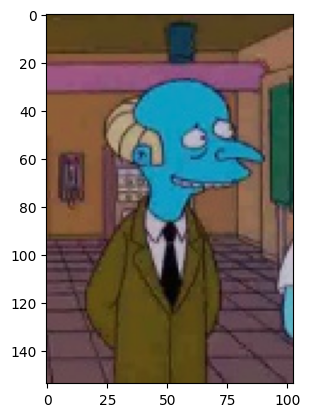

In [12]:
# Testing
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_0.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [13]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = image.reshape((1, IMG_SIZE[0], IMG_SIZE[1], 1))
    image = image / 255.0  # Normalize to [0,1]
    return image

predictions = model.predict(prepare(img))

# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
charles_montgomery_burns
